In [1]:
import numpy as np
import pandas as pd
import math
import sys, os
import mplcyberpunk
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color, to_hex
import matplotlib.colors as mc
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

plt.style.use("cyberpunk")

In [2]:
train_time = 1 * 60 * 60
objective = 'xgbhandregressor'

In [3]:
sys.path.append(os.path.realpath('..'))

In [4]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [10]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])
features = columns

# Rendering

In [11]:
plt.style.use("cyberpunk")

def render_xgb_features(model):
    histplot_hyperparams = {
            'alpha':0.4,
            #'stat':'percent',
            #'bins':100
            #'kde':True,
        }

    n_cols = 1
    n_rows = 1
    cell_with_dim = 20
    cell_height_dim = 5

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

    fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
    sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=features, **histplot_hyperparams)
    #sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

    mplcyberpunk.make_lines_glow(ax)
    plt.show()

In [12]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None, boarders=None):
    if boarders is not None:
        factor=1.0/max(boarders.values())
        for k in boarders:
            boarders[k] = boarders[k]*factor  
    
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) + 1 / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        print('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []
    
    hc = ['r', 'y', 'g']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)
 

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        
        if boarders is not None:
            c = to_hex(list(colormap(boarders[feature])))
            print(f'feature:{feature} color{c} row:{row} col{col}')
            linewidth = 2
            ax[row, col].spines['bottom'].set_color(c)
            ax[row, col].spines['bottom'].set_linewidth(linewidth)
            ax[row, col].spines['top'].set_color(c)
            ax[row, col].spines['top'].set_linewidth(linewidth)
            ax[row, col].spines['left'].set_color(c)
            ax[row, col].spines['left'].set_linewidth(linewidth)
            ax[row, col].spines['right'].set_color(c)
            ax[row, col].spines['right'].set_linewidth(linewidth)
            #ax[row, col].patch.set_linewidth('1')  
        
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [13]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

def render_cm(matrix):

    hc = ['#212946', '#FE53BB', '#F5D300']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)


    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.title('Confusion Matrix', y=1.08, fontsize = 20)
    res = sns.heatmap(matrix, annot=True, cmap=colormap, ax = ax, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('#08F7FE')

    xticks = ax.get_xticks()
    for i in range(len(xticks)-1):  
        ax.axvline( x=(xticks[i] + xticks[i+1]) / 2, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.5, color='#08F7FE')

    yticks = ax.get_yticks()
    for i in range(len(yticks)-1):  
        ax.axhline( y=(yticks[i] + yticks[i+1]) / 2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=0.5, color='#08F7FE')


    # plt.savefig("Heatmap.png")
    mplcyberpunk.make_lines_glow(ax, diff_linewidth=0.9)
    plt.show()

In [14]:
def feature_by_target(train_df):
    n_cols = 4
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    pad=2
    h_pad=4
    w_pad=None
    n_bins=50

    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    colors = ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733', 'g']

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)

    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
    axs = []
    for i, feature in tqdm(enumerate(features)):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols) 
        targets = train_df[target[0]].unique()
        for s, t in enumerate(targets):
            bp = ax[row, col].boxplot(x=train_df[train_df[target[0]] == t][feature], sym='k+', patch_artist=True, positions=[s], widths=cell_with_dim / (cell_with_dim + 2))
            c1 = colors[s]
            c2 = '#ffffff50'
            ax[row, col].set_title(feature)
            for box in bp['boxes']:
                box.set(color=c1, linewidth=1)
                box.set(facecolor=c1)
                r, g, b, a = box.get_facecolor()
                box.set_facecolor((r, g, b, .4)) # alpha layer
            for whisker in bp['whiskers']:
                whisker.set(color=c1, linewidth=1)
            for cap in bp['caps']:
                cap.set(color=c1, linewidth=1)
            for median in bp['medians']:
                median.set(color=c1)
            for flier in bp['fliers']:
                flier.set(color=c1, linewidth=1)
                flier.set(markeredgecolor=c1)

        mplcyberpunk.make_lines_glow(ax[row, col])

        axs.append(ax[row, col].get_legend_handles_labels())

11it [00:01,  7.73it/s]


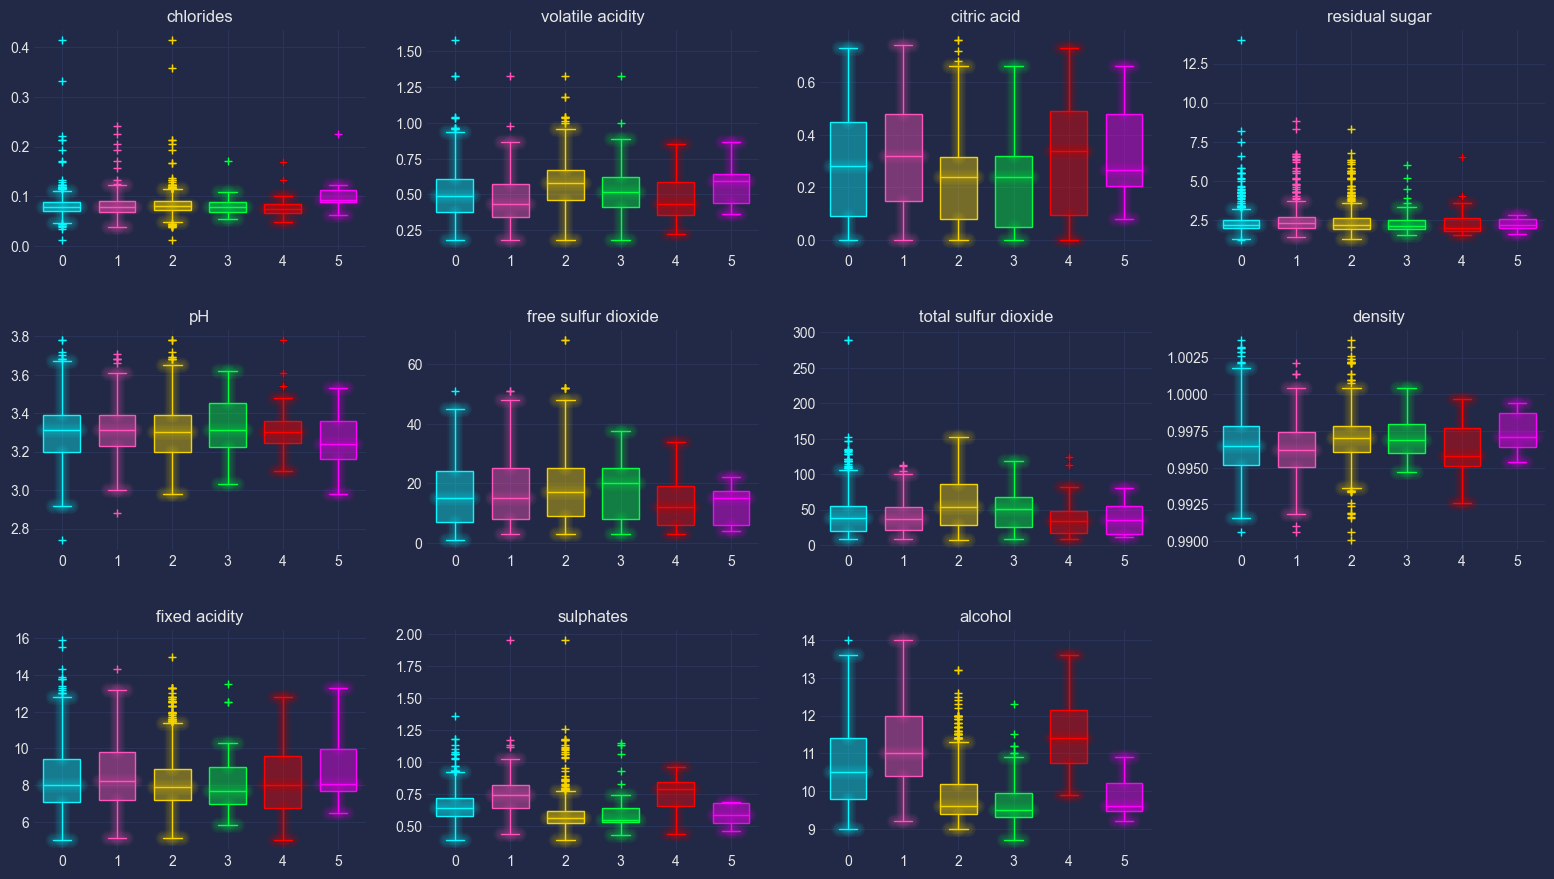

In [15]:
feature_by_target(train_df)

# PreProcessing

In [16]:
classes = train_df[target[0]].unique()
classes

array([6, 7, 5, 4, 8, 3], dtype=int64)

In [17]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

Starting Record Count: 2056
Checkpoint Record Count after removing outliers from sulphates: 2012
Checkpoint Record Count after removing outliers from density: 1971
Checkpoint Record Count after removing outliers from chlorides: 1968
Checkpoint Record Count after removing outliers from chlorides: 1948
Checkpoint Record Count after removing outliers from residual sugar: 1930
Checkpoint Record Count after removing outliers from residual sugar: 1908


11it [00:01,  7.40it/s]


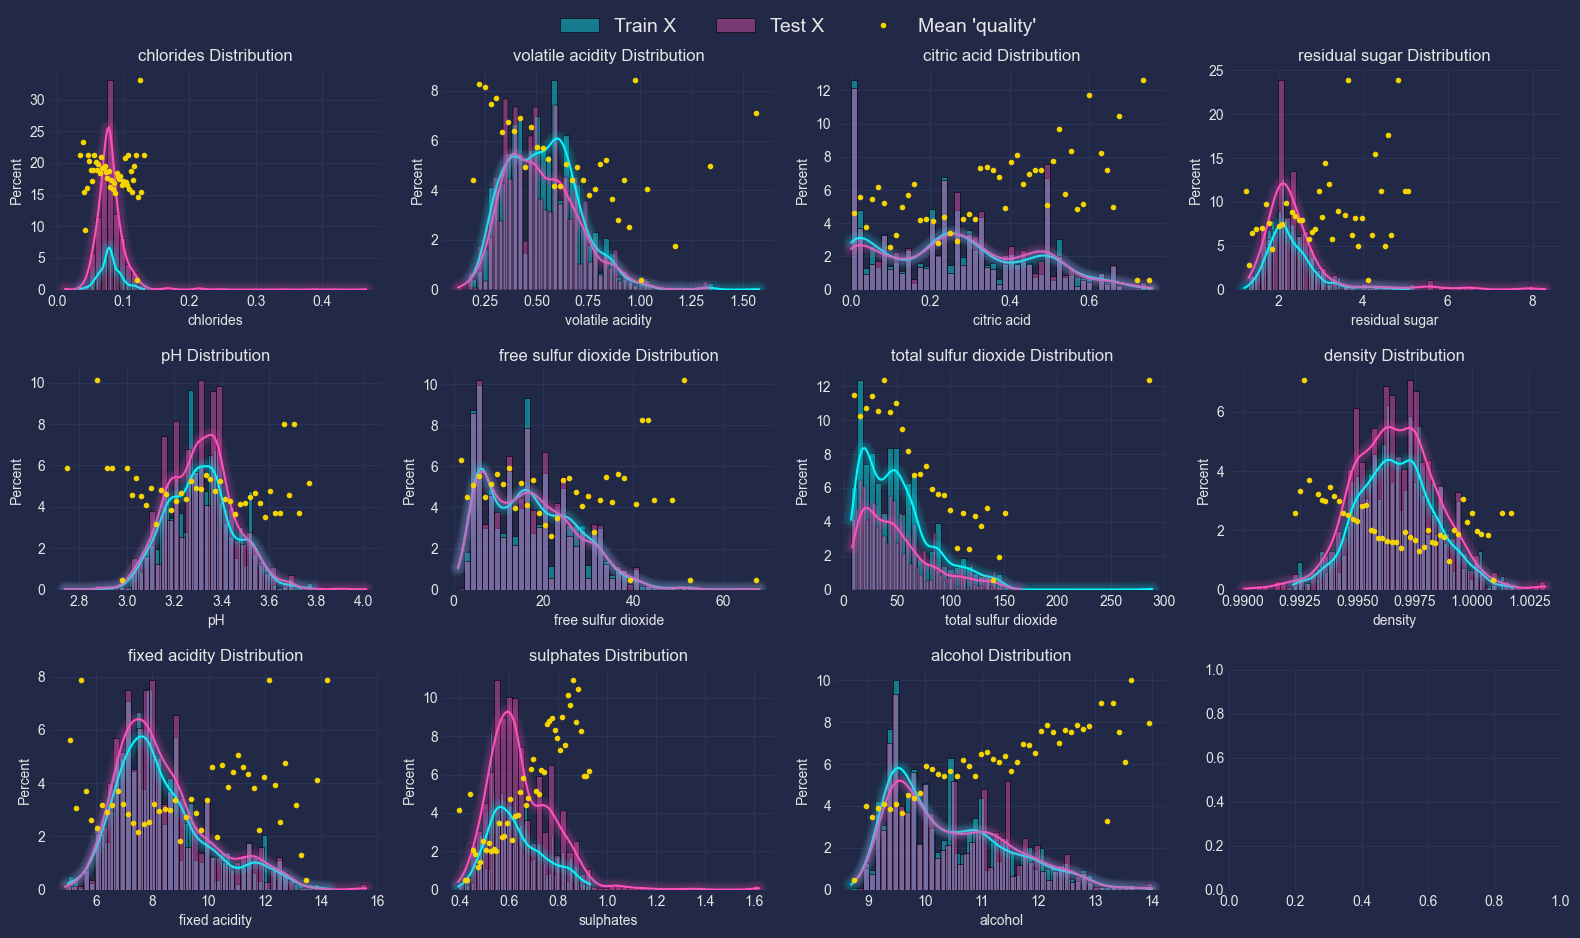

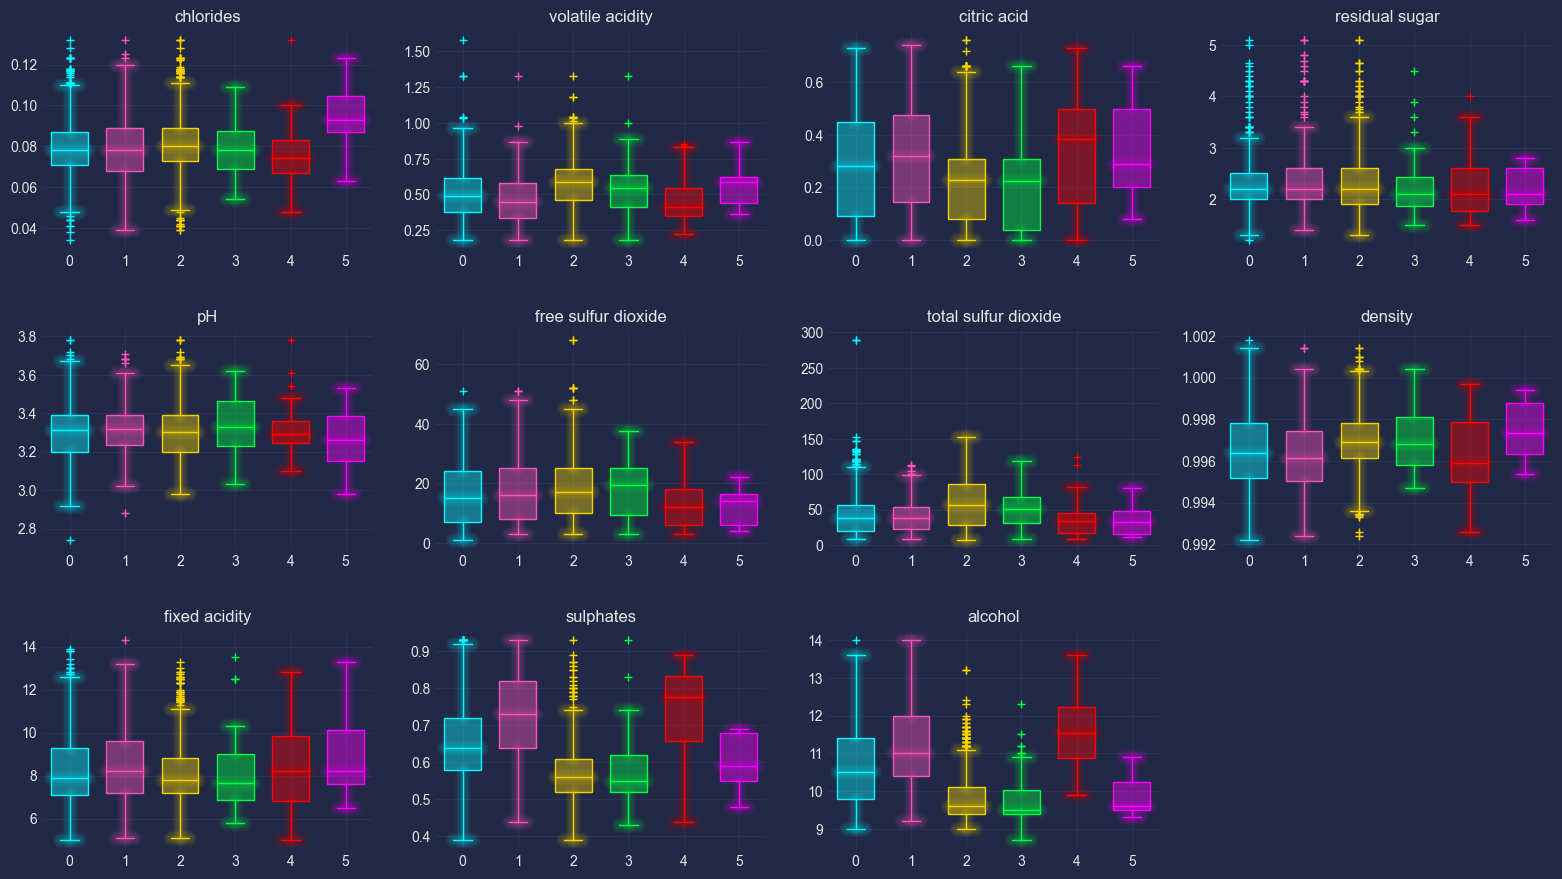

In [48]:
scrubbed_df = train_df.copy()

print(f'Starting Record Count: {len(scrubbed_df.index)}')

feature = 'sulphates'
specific_class = 2 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'density'
specific_class = 2 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'chlorides'
specific_class = 0 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'chlorides'
specific_class = 1 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'residual sugar'
specific_class = 1 + 3
std_multiplier = 4
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'residual sugar'
specific_class = 2 + 3
std_multiplier = 4
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

render_feature_distros(train_df=scrubbed_df, test_df=test_df, features=features, labels=[target[0]])
feature_by_target(scrubbed_df)


In [27]:
#train_df = scrubbed_df

In [240]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'xgb_first_quality'],
      dtype='object')

In [241]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])
features = columns

In [242]:
train_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0          0.724771          0.771429     0.486842        0.921875   0.848259   
1          0.605505          0.914286     0.039474        0.914062   0.800995   
2          0.807339          0.764286     0.960526        0.929688   0.883085   
3          0.715596          0.507143     0.710526        0.890625   0.820896   
4          0.678899          0.871429     0.605263        0.914062   0.833333   
...             ...               ...          ...             ...        ...   
2051       0.853211          0.907143     0.828947        0.937500   0.890547   
2052       0.568807          0.707143     0.723684        0.953125   0.833333   
2053       0.752294          0.821429     0.447368        0.960938   0.853234   
2054       0.623853          0.771429     1.000000        0.957031   0.885572   
2055       0.889908          0.907143     0.763158        0.914062   0.883085   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
Id                                                                    
0                0.567164              0.886525  0.585169  0.432692   
1                0.567164              0.787234  0.378120  0.442308   
2                0.970149              0.982270  0.520558  0.250000   
3                0.850746              0.794326  0.469163  0.557692   
4                0.865672              0.865248  0.679148  0.557692   
...                   ...                   ...       ...       ...   
2051             0.582090              0.875887  0.720264  0.250000   
2052             0.611940              0.794326  0.458150  0.615385   
2053             0.731343              0.893617  0.815712  0.442308   
2054             0.940299              0.978723  0.513216  0.538462   
2055             0.835821              0.925532  0.623348  0.211538   

      sulphates   alcohol  quality  xgb_first_quality  
Id                                                     
0      0.756410  0.358491        3                  3  
1      0.820513  0.226415        3                  3  
2      0.782051  0.509434        4                  4  
3      0.910256  0.792453        2                  2  
4      0.378205  0.849057        3                  2  
...         ...       ...      ...                ...  
2051   0.692308  0.377358        4                  4  
2052   0.878205  0.867925        2                  2  
2053   0.756410  0.283019        5                  3  
2054   0.980769  0.849057        2                  2  
2055   0.685897  0.490566        4                  4  

[1784 rows x 13 columns]

In [243]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))

KeyError: "['xgb_first_quality'] not in index"

In [244]:
scaler = MinMaxScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[target])
Y = scaler.transform(train_df[target])

KeyError: "['xgb_first_quality'] not in index"

In [245]:
#shrink for regressor
print(f'Before: {train_df[target[0]].unique()}')
train_df[target[0]] = train_df[target[0]] - np.min(train_df[target[0]].unique())
print(f'After:{train_df[target[0]].unique()}')

Before: [3 4 2 1 5 0]
After:[3 4 2 1 5 0]


# Train

In [246]:
def cohen_kappa_score_proxy(x, y):
    return cohen_kappa_score(x, y, weights='quadratic')

In [247]:
static_params = {
        'tree_method':'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 50
}

starting_parms = {

}

static_params.update(starting_parms)

print(f'tringing with:{static_params}')

model = xgb.XGBClassifier(**static_params, eval_metric=cohen_kappa_score_proxy)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.50)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = model.predict(train_df[features])
score = cohen_kappa_score_proxy(train_df[target], predictions)
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 50}
0.8506939973733679


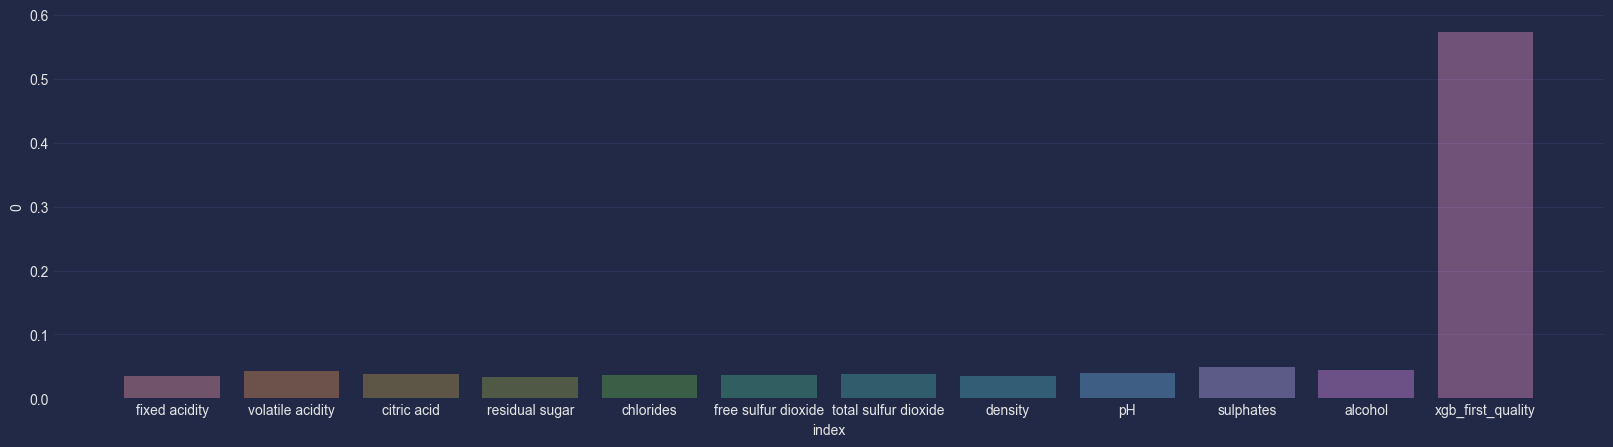

In [248]:
render_xgb_features(model)

In [249]:
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
fi_df.loc[0].to_dict()

{'fixed acidity': 0.034813590347766876,
 'volatile acidity': 0.04233343154191971,
 'citric acid': 0.03745940327644348,
 'residual sugar': 0.033488042652606964,
 'chlorides': 0.03667290136218071,
 'free sulfur dioxide': 0.036701831966638565,
 'total sulfur dioxide': 0.0384586863219738,
 'density': 0.034570205956697464,
 'pH': 0.039628732949495316,
 'sulphates': 0.04880262911319733,
 'alcohol': 0.043838415294885635,
 'xgb_first_quality': 0.5732321739196777}

feature:fixed acidity color#f81600 row:-1 col0
feature:volatile acidity color#f61b00 row:0 col1
feature:citric acid color#f71800 row:0 col2
feature:residual sugar color#f81500 row:0 col3
feature:chlorides color#f71800 row:0 col0
feature:free sulfur dioxide color#f71800 row:1 col1
feature:total sulfur dioxide color#f61a00 row:1 col2
feature:density color#f81600 row:1 col3
feature:pH color#f61a00 row:1 col0
feature:sulphates color#f42000 row:2 col1
feature:alcohol color#f61c00 row:2 col2


KeyError: 'xgb_first_quality'

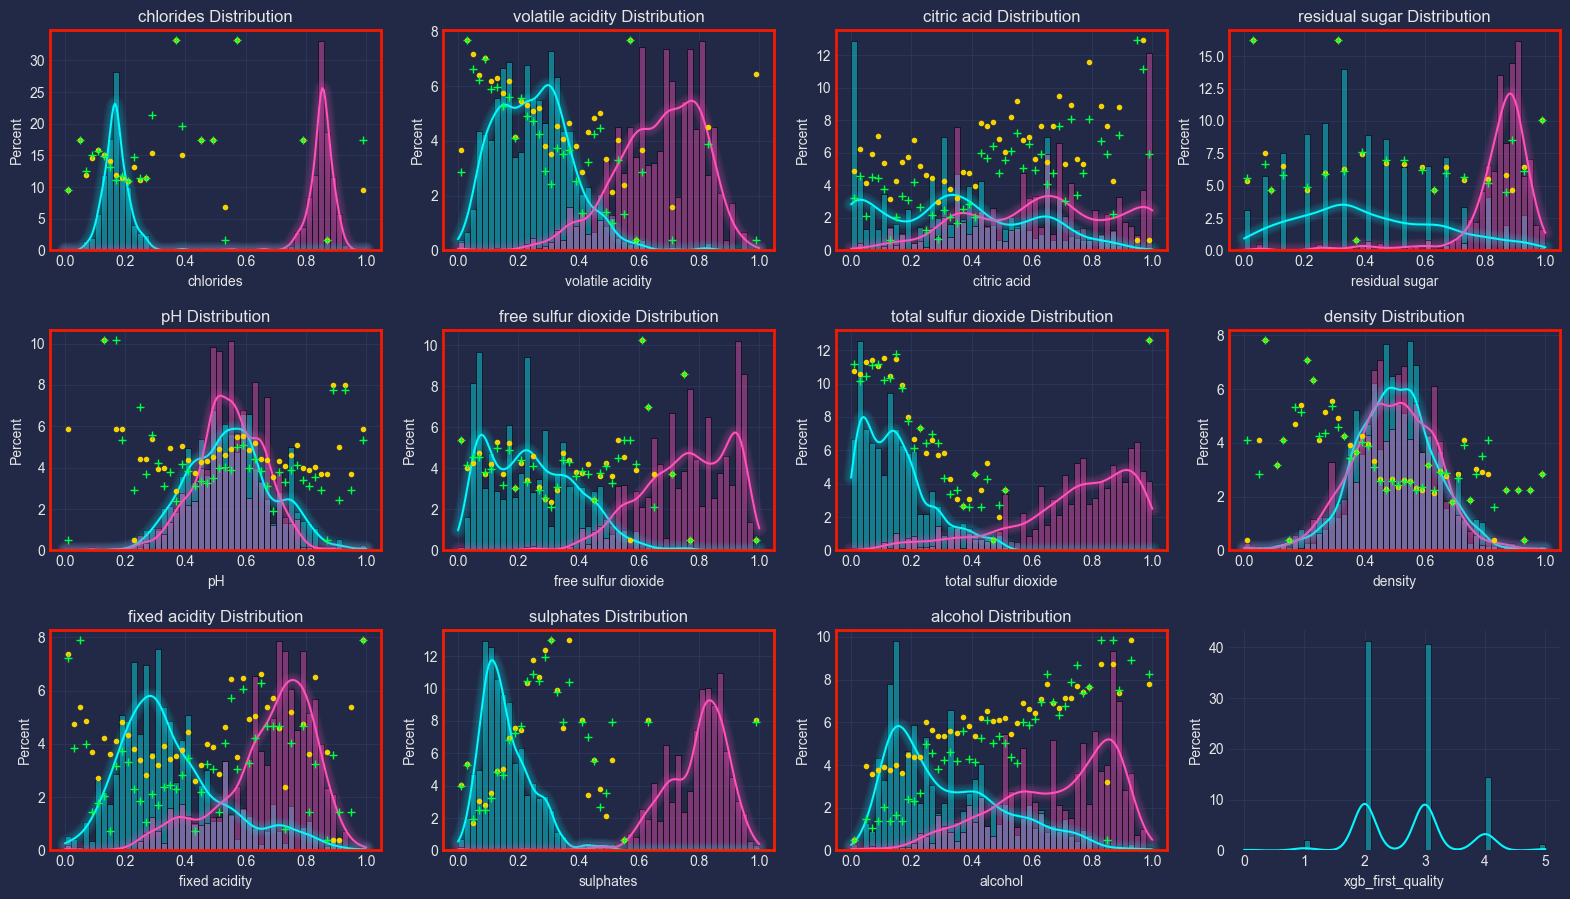

In [250]:
train_df[f'xgb_first_{target[0]}'] = predictions
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=fi_df.loc[0].to_dict())

In [ ]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)

In [ ]:
train_final_preds = model.predict(train_df[features])+3
test_final_preds = model.predict(test_df[features])+3

In [ ]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [46]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5, verbose=10)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, min_child_weight=1............................
[0]	validation_0-mlogloss:1.51252
[1]	validation_0-mlogloss:1.35260
[2]	validation_0-mlogloss:1.25713
[3]	validation_0-mlogloss:1.19035
[4]	validation_0-mlogloss:1.13396
[5]	validation_0-mlogloss:1.09399
[6]	validation_0-mlogloss:1.06775
[7]	validation_0-mlogloss:1.04928
[8]	validation_0-mlogloss:1.03343
[9]	validation_0-mlogloss:1.02054
[10]	validation_0-mlogloss:1.00972
[11]	validation_0-mlogloss:1.00420
[12]	validation_0-mlogloss:0.99810
[13]	validation_0-mlogloss:0.99572
[14]	validation_0-mlogloss:0.98986
[15]	validation_0-mlogloss:0.98967
[16]	validation_0-mlogloss:0.99133
[17]	validation_0-mlogloss:0.99114
[18]	validation_0-mlogloss:0.99018
[19]	validation_0-mlogloss:0.98893
[20]	validation_0-mlogloss:0.99034
[21]	validation_0-mlogloss:0.99374
[22]	validation_0-mlogloss:0.99542
[23]	validation_0-mlogloss:0.99625
[24]	validation_0-mlogloss:0

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=20000,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             verbose=10)

In [47]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 1}

In [48]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 1}

In [49]:
gsearch1.best_score_

0.5729761286974572

In [50]:
gsearch1.__dict__

{'scoring': None,
 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=20000,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               objective='multi:softmax', predictor=None, ...),
 'n_jobs': None,
 'refit': True,
 'cv': 5,
 'verbose': 10,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'max_depth': range(3, 10, 2),
  'min_child_

In [51]:
predictions = gsearch1.best_estimator_.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.4915646488041834


In [52]:

static_params.update(gsearch1.best_params_)
print(f'tringing with:{static_params}')
eval_model = xgb.XGBClassifier(**static_params)
X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
eval_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = eval_model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions, weights='quadratic')
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 20000, 'max_depth': 3, 'min_child_weight': 1}
0.4726783631800887


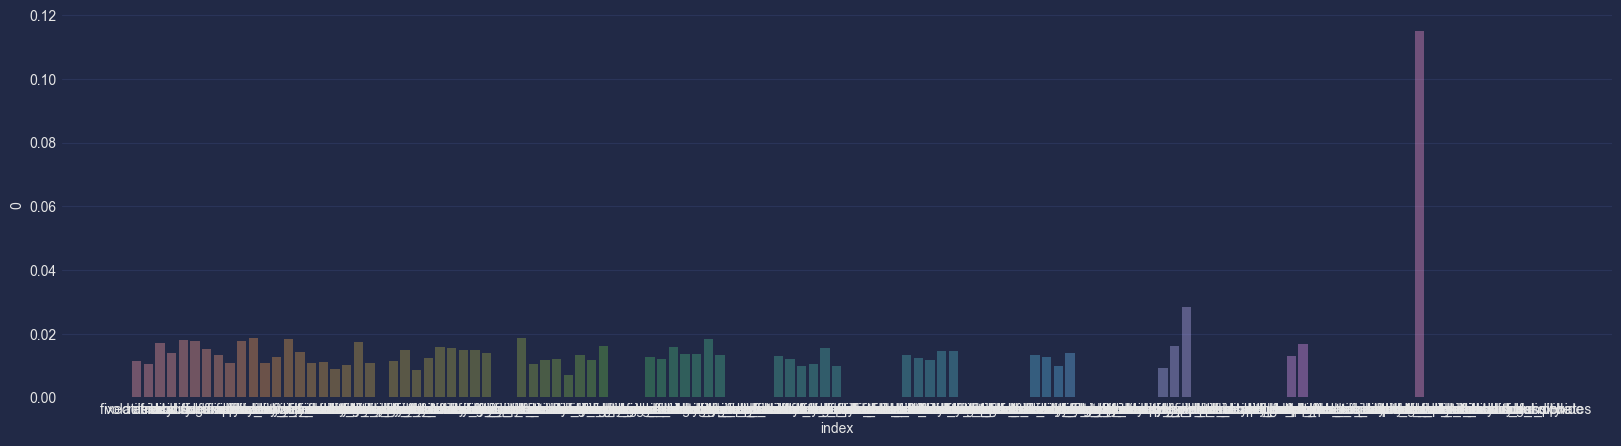

In [53]:
render_xgb_features(model)

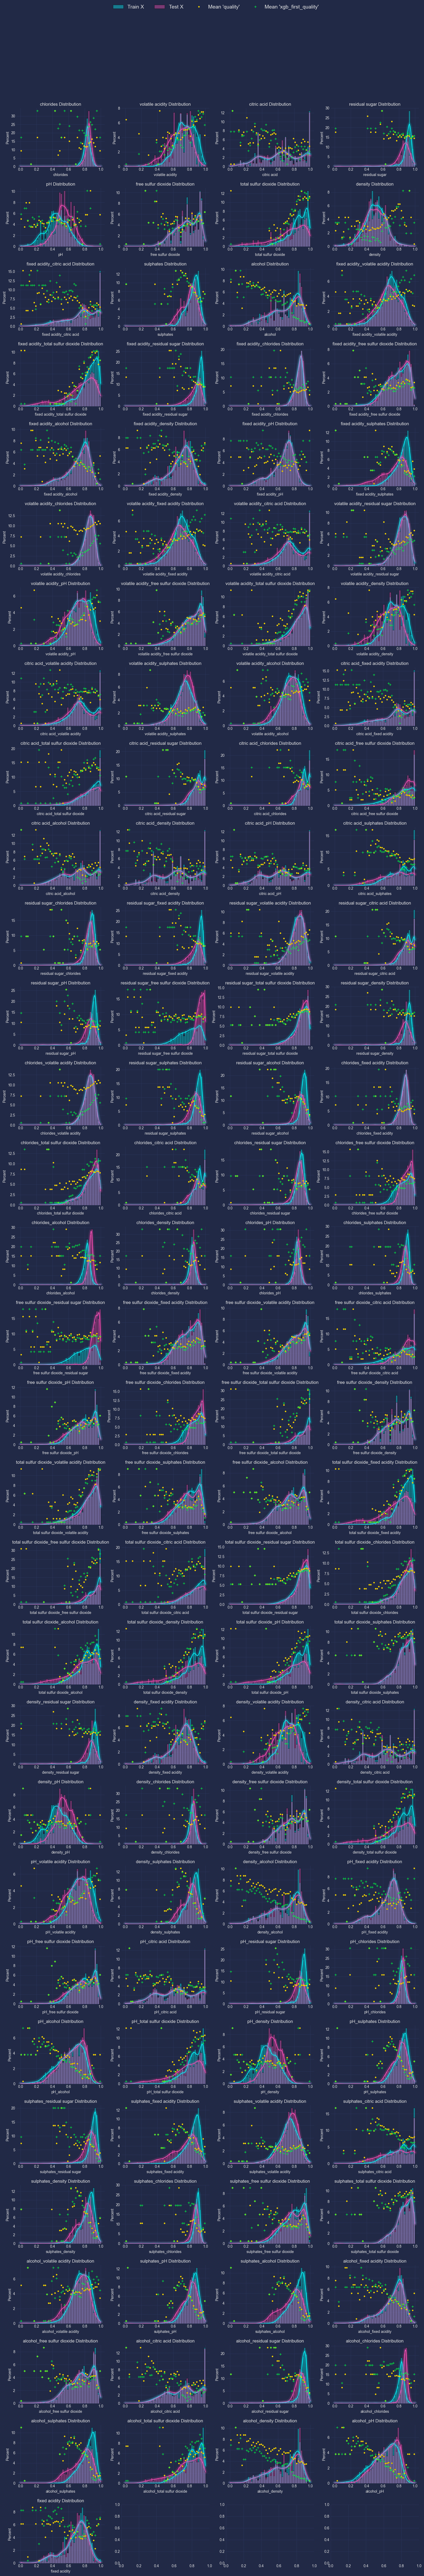

In [54]:
train_df[f'xgb_first_{target[0]}'] = predictions
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'])

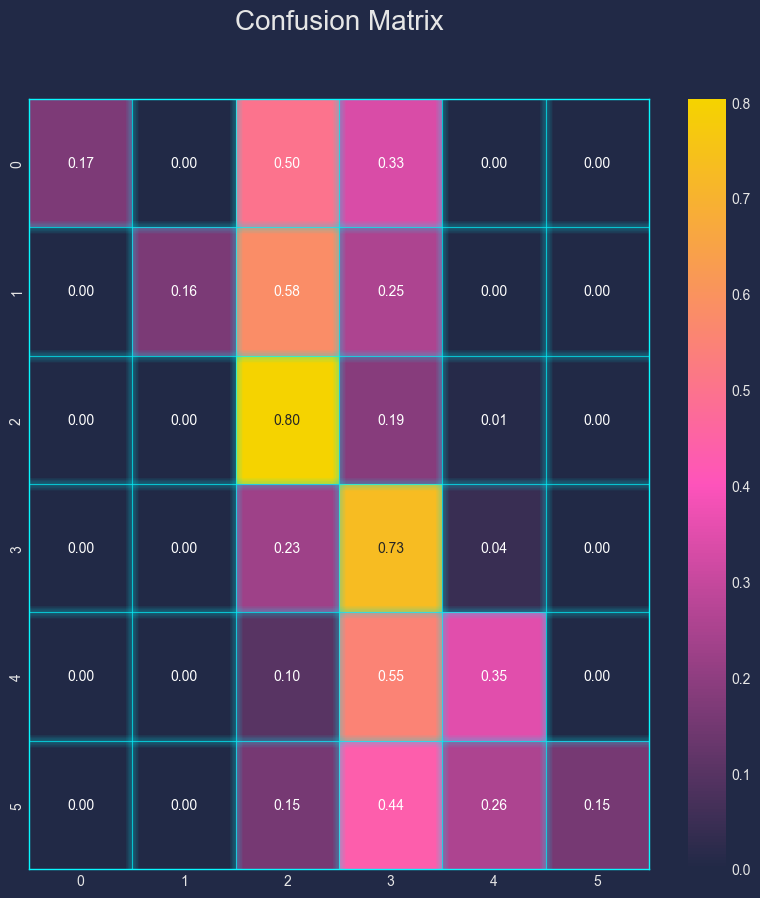

In [55]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)